In [1]:
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy

C:\Users\kusljic\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Prvo ćemo definisati konstante koje ćemo koristiti za prediktovane klase, kao i za hiperparametre modela. Definisemo alfabet kojeg sačinjavaju nazivi vrsta cvijeća koji su dati u trening i test skupovima podataka. Takođe definišemo putanju do podataka trening skupa kao i veličinu slika koje proslijeđujemo neuronskoj mreži za klasifikaciju. Pomoćna metoda label_name_to_output za dati naziv vrste cvijeća formira vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu vrstu cvijeća. Parametar RETRAIN označava da li treba da se pokuša ponovno treniranje neuronske mreže ili da se koriste sačuvane težine neke prethodno trenirane neuronske mreže. Parametar TRAINED_WEIGHTS_DIR određuje koje težine se učitavaju ako je parametar RETRAIN podešen na False.

In [2]:
ALPHABET = ["snowdrop", "lilyvalley", "bluebell", "tigerlily", "fritillary"]
ALPHABET_USER_FRIENDLY = ["Snowdrop", "Lily valley", "Bluebell", "Tiger lily", "Fritillary"]
DATADIR = "data/train"
TEST_DATADIR = "data/test"
IMAGE_SIZE = 128

RETRAIN = False
TRAINED_WEIGHTS_DIR = "./model_weigths/acc89/acc89"


def label_name_to_output(class_name):
    return [float(class_name == x) for x in ALPHABET]

name_to_out_test = "bluebell"
name_to_out_expected = [0.0, 0.0, 1.0, 0.0, 0.0]
name_to_out_res = label_name_to_output(name_to_out_test)
print("Name to output tet passed:", name_to_out_res == name_to_out_expected)

Name to output tet passed: True


Definišemo pomoćne funkcije za učitavanje slika testnog skupa podataka. Podaci prolaze pretprocesiranje tako da se svaka slika skalira na zadate dimenzije i za njenu klasu određuje se vektor koji predstavlja očekivani izlaz iz neuronske mreže za datu klasu. Pretprocesirani podaci se cuvaju u pomocnom fajlu radi lakseg ucitavanja.

In [3]:
def load_data():
    images = []
    target_outputs = []
    train_labels = pd.read_csv(os.path.join(DATADIR, "train_labels.csv"))
    
    for img in os.listdir(DATADIR):
        if img[-4:] != ".jpg":
            continue
        
        data_instance = cv2.imread(os.path.join(DATADIR, img))  # load image
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB) # convert from BGR to RGB color model
        images.append(data_instance)
        img_label_name = train_labels.loc[train_labels['file'] == img, 'labels'].iloc[0]
        target_output = label_name_to_output(img_label_name)
        target_outputs.append(target_output)
        
    return images, target_outputs

def resize_image(image):
    return cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

def get_preprocessed_data():
    resized_images = []
    outputs = []
    preprocessed_data_file_path = os.path.join(DATADIR, "preprocessed_data.bin")
    if os.path.exists(preprocessed_data_file_path):
        preprocessed_data_file = open(preprocessed_data_file_path, "rb")
        resized_images, outputs = pickle.load(preprocessed_data_file)
        preprocessed_data_file.close()
        print("Loaded preprocessed data file.")
    else:
        # load data
        images, outputs = load_data()
        # resize images to same dimensions
        resized_images = []
        for img in images:
            resized_images.append(resize_image(img))
        # save preprocessed date to disk for easier future use
        preprocessed_data_file = open(preprocessed_data_file_path, "wb")
        preprocessed_data = (resized_images, outputs)
        pickle.dump(preprocessed_data, preprocessed_data_file)
        preprocessed_data_file.close()
        print("Created preprocessed data file.")
            
    return resized_images, outputs
        

Definišemo funkciju koja inicijalizije neuronsku mrežu koju ćemo koristiti za klasifikaciju. Pošto je trening skup
relativno mali koristićemo transfer learning. Za onsovu modela iskoristićemo MobileNetV2 konvolucionu neuronsku mrežu
kaja je već trenirana na image-net skupu podataka. Ova mreža će nam poslužiti za ekstrakciju bitnih karakteristika slike. Pošto je ova mreža (base_model u kodu ispod) već istrenirana nju ne želimo ponovo da treniramo, pa setujemo trainable na False. Originalna mreža je dizajnirana da prepoznaje 1000 klasa. Mi ćemo je prilagoditi za prepoznavanje zadatih 5 klasa. Najprije odbacujemo slojeve za klasifikaciju iz originalne mreže (include_top = False). Zatim na mrežu nadovezujemo sopstveni sloj za klasifikaciju. Ovaj sloj sadrži 5 neurona sa softmax aktivacijom. Na taj način izlaz svakog neurona biće sveden na interval [0, 1] i odgovara vjerovatnoći da slika pripada klasi koju dati neuron predviđa.

In [4]:
def create_model():
    base_model = tensorflow.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')
    base_model.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(len(ALPHABET), activation='softmax'))
    
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Definišemo pomoćne funkcije za obučavanje neuronske mreže. Prilikom obučavanja koristimo Stochastic gradient descent algoritam. Za validaciju modela tokom obučavanja koristićemo kros-validaciju, pri čemo se 90% trening skupa koristi za obučvanje modela a 10% trening skupa za validaciju modela. Pomoćna metoda plot_train_history služi za vizualizaciju vrijednosti greške i preceznosti tokom treniranja, kroz epohe.

In [5]:
def plot_train_history(hist, epochs):
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['acc']
    val_acc=hist.history['val_acc']
    xc=range(epochs)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'])

def train_model(model, epochs_num):
    # ucitavanje podataka iz trening skupa
    X, y = get_preprocessed_data()
    # prilagodjavanje podataka formatu koji tensorflow biblioteka ocekuje
    X = np.array(X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    y = np.array(y)
    print("Sample image:")
    plt.imshow(X[0])
    plt.show()
    print("Expected output for this image:", y[0])
    
    # treniranje mreze nad ucitanim podacija
    train_history = model.fit(X, y, batch_size=32, validation_split=0.1, epochs=epochs_num, shuffle=True)
    
    return train_history
    
    

Instanciramo neuronsku mrežu. Ukoloko je parametar RETRAIN podešen na True vršimo učitavanje i pretprocesiranje podataka iz trening skupa i obučavanje meže nad učitanim podacima. U suprotnom učitaćemo u meržu težine modela koji je prethodno već treniran i postiže zadovoljavajuće rezultate na trening skupu podataka.


In [6]:
model = create_model()
epochs_num = 40
train_history = None
if(RETRAIN):
    train_history = train_model(model, epochs_num)  
else:
    model.load_weights(TRAINED_WEIGHTS_DIR)
    print("Loaded model.")


Loaded model.


In [7]:
if(RETRAIN):
    print("Train history visualization:\n")
    plot_train_history(train_history, epochs_num)

Definišemo pomoćne funkcije za učitavanje podataka iz test skupa i evaluaciju predikcija modela na test skupu. Takođe definišemo metodu za pohranjivanje težina modela da bismo mogli dati model ponovo iskoristiti ako se dobro pokaže na test podacima.


In [8]:
def load_test_data():
    images = []
    labels = []
    test_labels = pd.read_csv(os.path.join(TEST_DATADIR, "test_labels.csv"))
    
    for img in os.listdir(TEST_DATADIR):
        if img[-4:] != ".jpg":
            continue
        
        data_instance = cv2.imread(os.path.join(TEST_DATADIR, img))  # load image
        data_instance = cv2.cvtColor(data_instance, cv2.COLOR_BGR2RGB) # convert from BGR to RGB color model
        
        images.append(resize_image(data_instance))
        img_label_name = test_labels.loc[test_labels['file'] == img, 'labels'].iloc[0]
        label = label_name_to_output(img_label_name)
        labels.append(label)
        
    return images, labels

def visualize_predictions(model, test_images):
    print("Model predictions visualization:")
    predictions = model.predict(test_images, verbose=1)
    print()
    for i in range(len(predictions)):
        image = test_images[i]
        prediction = predictions[i]
        idx = np.argmax(prediction)
        predicted_label = ALPHABET_USER_FRIENDLY[idx]
        print("Image", i + 1)
        plt.imshow(image)
        plt.show()
        print("Class probabilities:", prediction)
        print("Predicted label:", predicted_label)
        print()

def test_model(model, visualize=True):
    # ucitavanje test podataka
    test_X, test_y = load_test_data()
    # prilagodjavanje podataka formatu koji ocekuje tensorflow biblioteka
    test_X = np.array(test_X).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
    test_y = np.array(test_y)
    
    # prikaz predikcija modela za test podatke
    if(visualize):
        visualize_predictions(model, test_X)
    
    # evaluacija performansi modela nad test podacima
    loss, accuracy = model.evaluate(test_X, test_y, verbose=1)
    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print()
    return accuracy
    
def save_weigths(model, test_accuracy):
    rough_accuracy = round(test_accuracy, 2)
    rough_accuracy *= 100
    rough_accuracy = int(rough_accuracy)
    dest = './model_weigths/acc' + str(rough_accuracy) + '/acc' + str(rough_accuracy)
    model.save_weights(dest)
    

Vršimo učitavanje podataka iz test skupa i evaluaciju performansi modela na test skupu. Sačuvamo težine datog modela ukoliko već nisu sačuvane kako bismo ih mogli ponovo koristiti.

Model predictions visualization:
80/80 [==============================] - 2s 30ms/step

Image 1


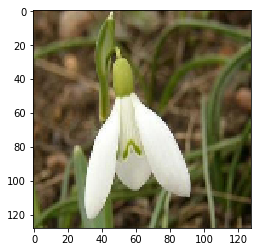

Class probabilities: [0.90093815 0.02425733 0.04296361 0.01707317 0.01476774]
Predicted label: Snowdrop

Image 2


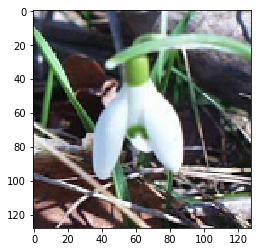

Class probabilities: [0.58327186 0.03807825 0.00312883 0.15644692 0.21907409]
Predicted label: Snowdrop

Image 3


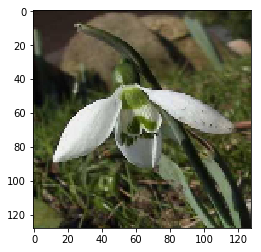

Class probabilities: [0.6437357  0.12443741 0.10359562 0.00694408 0.12128717]
Predicted label: Snowdrop

Image 4


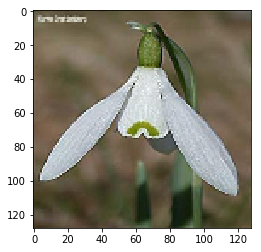

Class probabilities: [0.44529888 0.12081734 0.25502002 0.03817087 0.14069292]
Predicted label: Snowdrop

Image 5


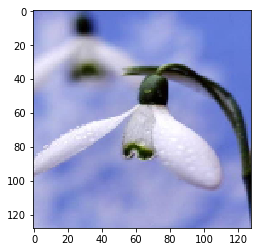

Class probabilities: [9.8624599e-01 1.1383873e-02 1.4979767e-03 7.0725000e-05 8.0136920e-04]
Predicted label: Snowdrop

Image 6


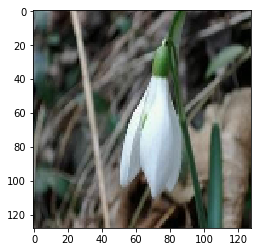

Class probabilities: [9.9103558e-01 4.5298111e-05 8.0327905e-04 1.4983695e-04 7.9659969e-03]
Predicted label: Snowdrop

Image 7


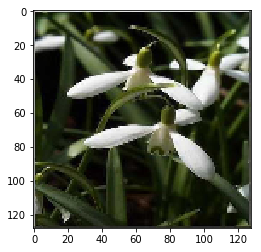

Class probabilities: [6.1380243e-01 2.4284238e-03 3.8263032e-01 1.4855512e-04 9.9026121e-04]
Predicted label: Snowdrop

Image 8


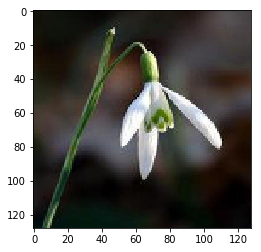

Class probabilities: [0.6755998  0.01739764 0.09753808 0.00999753 0.19946691]
Predicted label: Snowdrop

Image 9


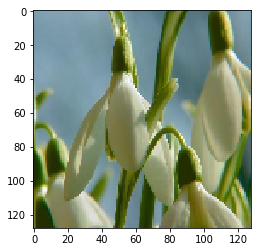

Class probabilities: [0.9087324  0.01346915 0.00239973 0.01827953 0.05711915]
Predicted label: Snowdrop

Image 10


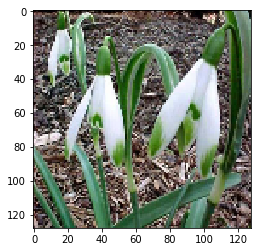

Class probabilities: [0.58754253 0.02368059 0.3043692  0.04567005 0.03873761]
Predicted label: Snowdrop

Image 11


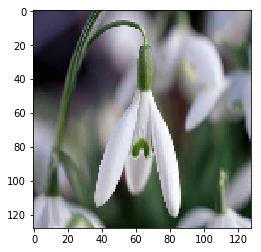

Class probabilities: [9.4634038e-01 5.4840976e-03 9.5926672e-03 3.2564110e-04 3.8257301e-02]
Predicted label: Snowdrop

Image 12


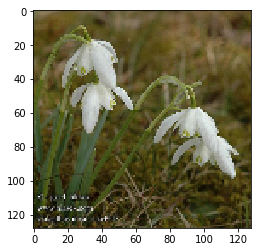

Class probabilities: [0.7063653  0.03119175 0.15782608 0.07111172 0.03350513]
Predicted label: Snowdrop

Image 13


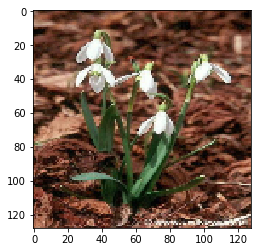

Class probabilities: [8.7188983e-01 3.1042428e-04 4.2207014e-02 7.9372078e-02 6.2206592e-03]
Predicted label: Snowdrop

Image 14


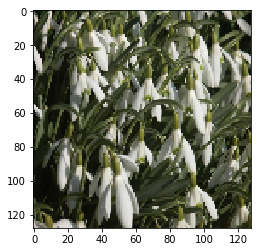

Class probabilities: [9.9292457e-01 1.7190606e-03 4.4678324e-03 7.8431665e-05 8.1010733e-04]
Predicted label: Snowdrop

Image 15


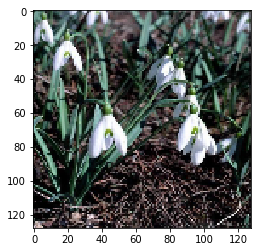

Class probabilities: [0.95356745 0.00189313 0.0098588  0.01929679 0.01538382]
Predicted label: Snowdrop

Image 16


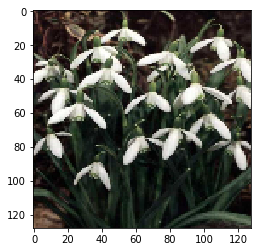

Class probabilities: [0.8685539  0.10451891 0.01596171 0.00471348 0.00625208]
Predicted label: Snowdrop

Image 17


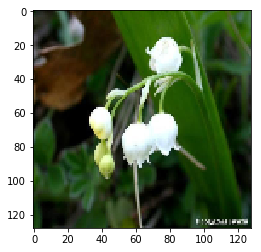

Class probabilities: [0.09538668 0.5823552  0.20247653 0.11441447 0.0053672 ]
Predicted label: Lily valley

Image 18


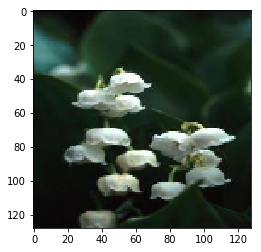

Class probabilities: [1.3538266e-02 9.8473030e-01 1.5966854e-03 3.7377176e-05 9.7488140e-05]
Predicted label: Lily valley

Image 19


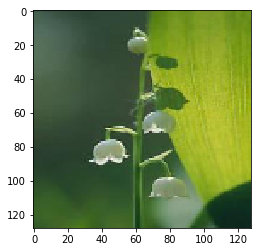

Class probabilities: [1.923289e-03 6.821166e-01 3.155101e-01 8.337469e-05 3.666075e-04]
Predicted label: Lily valley

Image 20


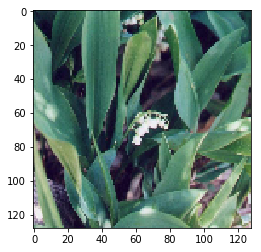

Class probabilities: [0.7812241  0.01671778 0.10429097 0.03119878 0.06656845]
Predicted label: Snowdrop

Image 21


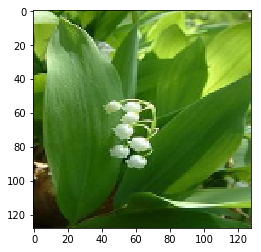

Class probabilities: [1.3742865e-03 9.9547869e-01 1.8721076e-03 9.7383299e-06 1.2651540e-03]
Predicted label: Lily valley

Image 22


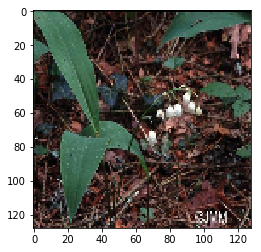

Class probabilities: [0.62422264 0.19821846 0.01100702 0.1435637  0.02298816]
Predicted label: Snowdrop

Image 23


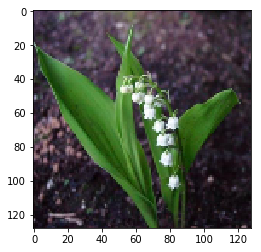

Class probabilities: [0.01432865 0.9060616  0.03061561 0.0079956  0.04099861]
Predicted label: Lily valley

Image 24


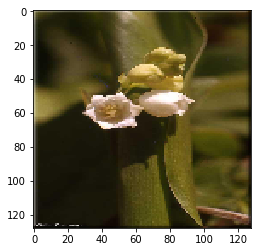

Class probabilities: [0.00842143 0.96354175 0.00612852 0.01472759 0.00718072]
Predicted label: Lily valley

Image 25


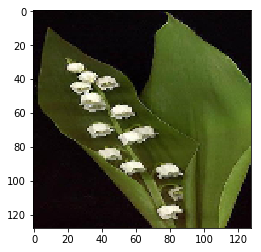

Class probabilities: [7.6124929e-03 9.8143101e-01 1.0012749e-02 6.4399239e-04 2.9975158e-04]
Predicted label: Lily valley

Image 26


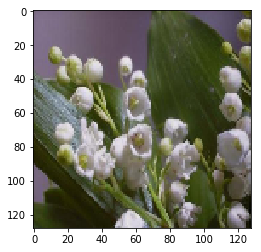

Class probabilities: [2.5523291e-03 9.9481261e-01 9.3377725e-04 2.7749033e-04 1.4238042e-03]
Predicted label: Lily valley

Image 27


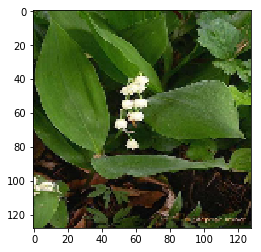

Class probabilities: [0.00749556 0.9520834  0.02699243 0.01191123 0.0015173 ]
Predicted label: Lily valley

Image 28


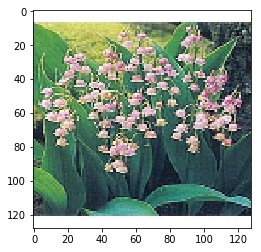

Class probabilities: [0.3201329  0.5018685  0.01526337 0.142965   0.01977028]
Predicted label: Lily valley

Image 29


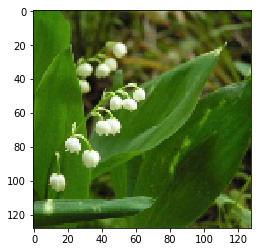

Class probabilities: [2.2246842e-03 9.8920220e-01 3.0843278e-03 5.4287976e-03 5.9921858e-05]
Predicted label: Lily valley

Image 30


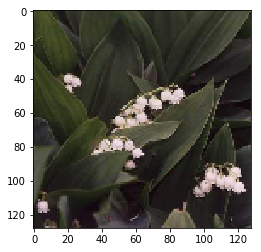

Class probabilities: [3.4007024e-02 9.3139356e-01 3.3662766e-02 2.5143259e-04 6.8517966e-04]
Predicted label: Lily valley

Image 31


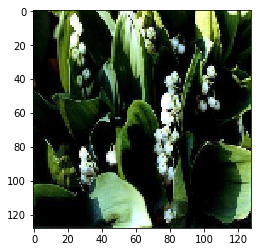

Class probabilities: [0.18490052 0.74543464 0.00847608 0.03649746 0.02469129]
Predicted label: Lily valley

Image 32


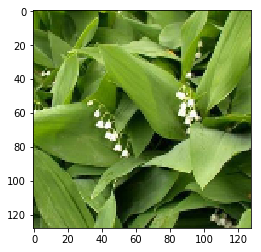

Class probabilities: [0.1711463  0.40824246 0.4161051  0.0015618  0.00294439]
Predicted label: Bluebell

Image 33


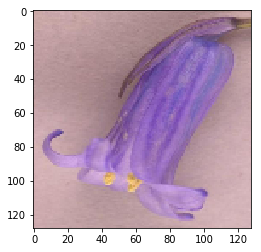

Class probabilities: [0.47709116 0.0976441  0.22700189 0.00300941 0.19525348]
Predicted label: Snowdrop

Image 34


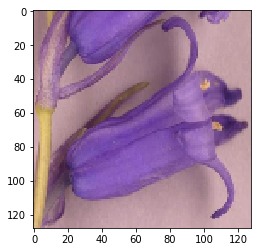

Class probabilities: [0.5789395  0.02803228 0.3314674  0.00822671 0.05333416]
Predicted label: Snowdrop

Image 35


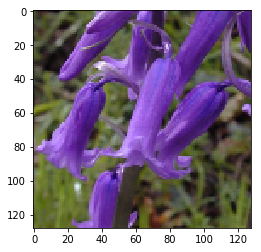

Class probabilities: [0.02806556 0.00867181 0.9570103  0.00142977 0.00482244]
Predicted label: Bluebell

Image 36


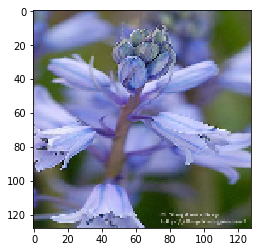

Class probabilities: [0.42255735 0.22387472 0.32389665 0.02355484 0.00611643]
Predicted label: Snowdrop

Image 37


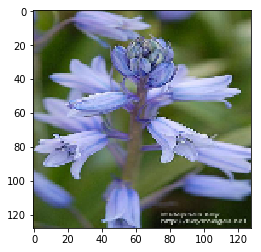

Class probabilities: [0.00320741 0.02446042 0.9478412  0.02279972 0.0016911 ]
Predicted label: Bluebell

Image 38


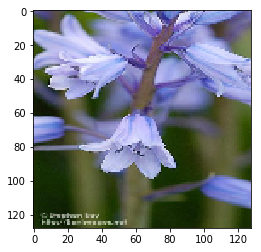

Class probabilities: [0.04580765 0.31408656 0.5896219  0.0352484  0.01523552]
Predicted label: Bluebell

Image 39


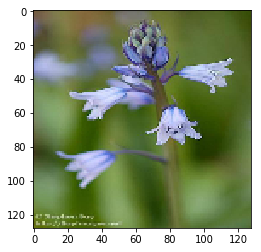

Class probabilities: [0.01911755 0.0390886  0.93125397 0.0076263  0.00291358]
Predicted label: Bluebell

Image 40


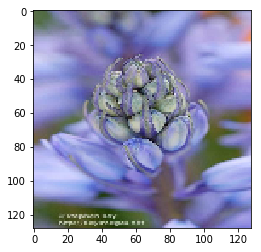

Class probabilities: [0.02124319 0.34586316 0.37397406 0.03241826 0.22650135]
Predicted label: Bluebell

Image 41


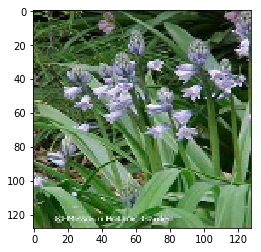

Class probabilities: [0.86858994 0.01394842 0.10097297 0.00992706 0.00656157]
Predicted label: Snowdrop

Image 42


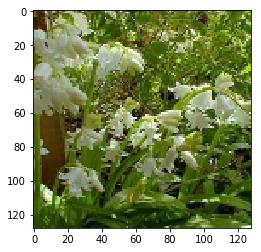

Class probabilities: [0.14750212 0.7579951  0.06934432 0.01991342 0.00524492]
Predicted label: Lily valley

Image 43


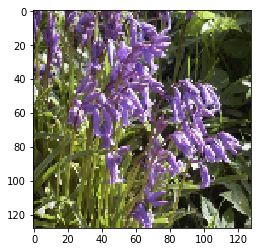

Class probabilities: [0.0087434  0.01508752 0.964093   0.00668773 0.00538827]
Predicted label: Bluebell

Image 44


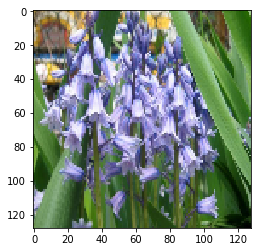

Class probabilities: [0.0554803  0.06378473 0.8730433  0.00533459 0.0023571 ]
Predicted label: Bluebell

Image 45


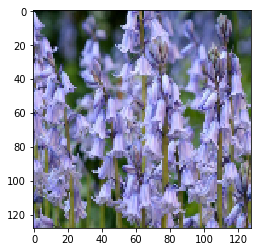

Class probabilities: [0.00319683 0.01668581 0.97352886 0.00509014 0.00149835]
Predicted label: Bluebell

Image 46


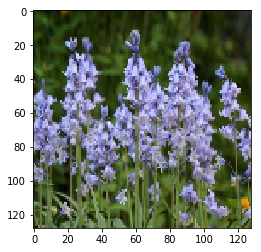

Class probabilities: [0.25480273 0.09497669 0.62255603 0.02296868 0.00469587]
Predicted label: Bluebell

Image 47


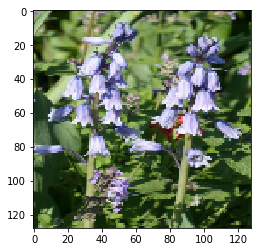

Class probabilities: [0.01227768 0.01579592 0.9539178  0.0126981  0.00531051]
Predicted label: Bluebell

Image 48


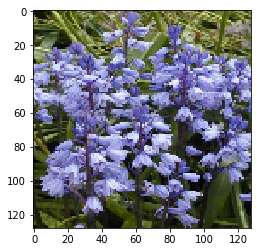

Class probabilities: [0.1581934  0.05807987 0.77524215 0.00651779 0.00196671]
Predicted label: Bluebell

Image 49


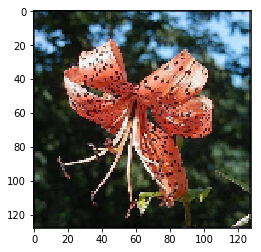

Class probabilities: [0.00152846 0.00150074 0.01458136 0.97763526 0.00475414]
Predicted label: Tiger lily

Image 50


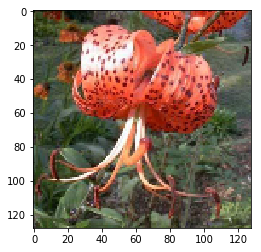

Class probabilities: [2.3736892e-04 2.2664152e-03 1.2830031e-02 9.0964669e-01 7.5019591e-02]
Predicted label: Tiger lily

Image 51


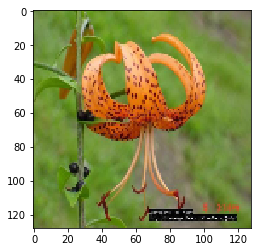

Class probabilities: [0.00157803 0.01103668 0.10652623 0.8424229  0.03843608]
Predicted label: Tiger lily

Image 52


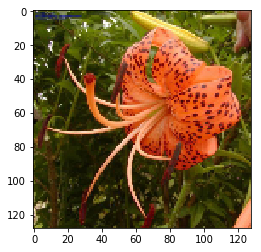

Class probabilities: [0.00462963 0.0041935  0.54185075 0.3815529  0.06777328]
Predicted label: Bluebell

Image 53


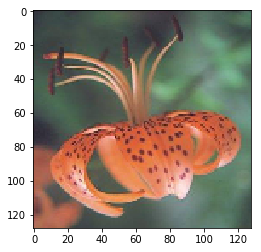

Class probabilities: [0.14597568 0.07474747 0.15451843 0.3798658  0.24489258]
Predicted label: Tiger lily

Image 54


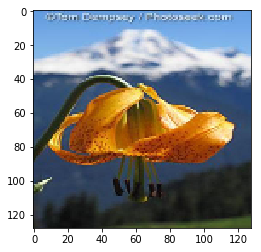

Class probabilities: [0.00976287 0.00465571 0.06840383 0.91401476 0.00316289]
Predicted label: Tiger lily

Image 55


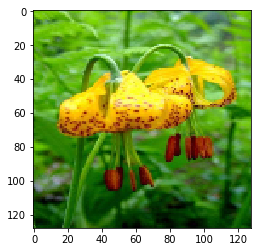

Class probabilities: [0.05489507 0.0107555  0.27760825 0.5413516  0.11538953]
Predicted label: Tiger lily

Image 56


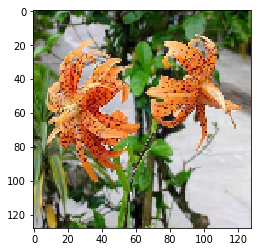

Class probabilities: [1.3640706e-03 2.6261876e-04 3.0600538e-03 9.9503136e-01 2.8185063e-04]
Predicted label: Tiger lily

Image 57


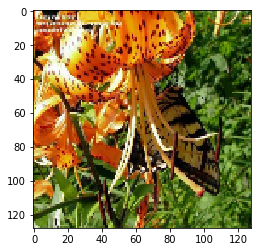

Class probabilities: [0.01564608 0.011099   0.03785996 0.9315714  0.00382354]
Predicted label: Tiger lily

Image 58


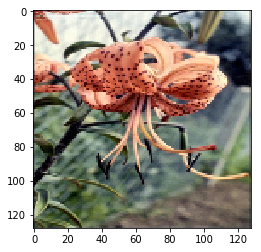

Class probabilities: [3.1581486e-03 7.8947889e-04 1.7349581e-03 9.9030453e-01 4.0130266e-03]
Predicted label: Tiger lily

Image 59


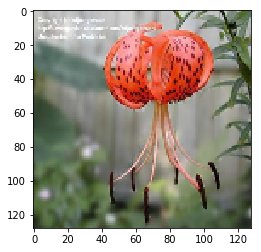

Class probabilities: [7.2916190e-04 1.9904397e-02 1.2837312e-01 8.0593580e-01 4.5057490e-02]
Predicted label: Tiger lily

Image 60


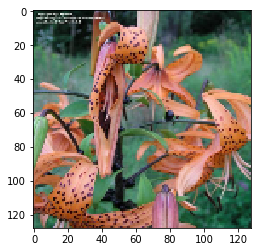

Class probabilities: [3.0788917e-02 2.6018661e-04 4.6671014e-02 9.1417331e-01 8.1065521e-03]
Predicted label: Tiger lily

Image 61


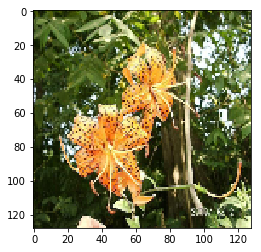

Class probabilities: [0.09292264 0.00509753 0.16694665 0.72628456 0.00874852]
Predicted label: Tiger lily

Image 62


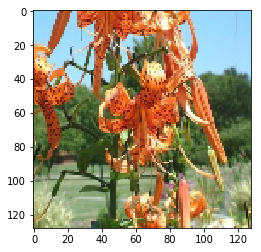

Class probabilities: [0.00379184 0.00559776 0.05558755 0.9264294  0.00859337]
Predicted label: Tiger lily

Image 63


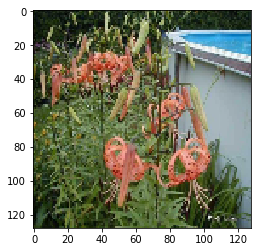

Class probabilities: [0.00459475 0.00099466 0.01379    0.978301   0.00231964]
Predicted label: Tiger lily

Image 64


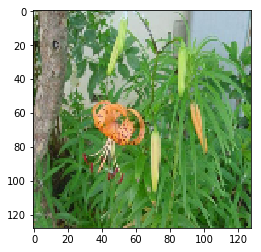

Class probabilities: [1.4995132e-03 1.9555884e-04 1.7479828e-02 9.8014563e-01 6.7940139e-04]
Predicted label: Tiger lily

Image 65


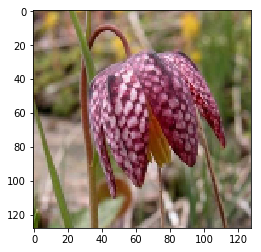

Class probabilities: [0.00445098 0.00150847 0.00382209 0.03573071 0.95448774]
Predicted label: Fritillary

Image 66


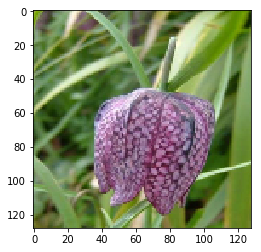

Class probabilities: [0.00181168 0.00448643 0.00362728 0.00927424 0.9808004 ]
Predicted label: Fritillary

Image 67


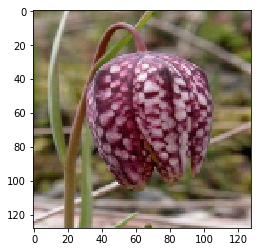

Class probabilities: [9.2108552e-05 2.8313574e-05 7.6425291e-04 1.5468831e-05 9.9909985e-01]
Predicted label: Fritillary

Image 68


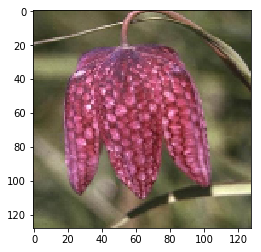

Class probabilities: [1.1174525e-04 6.1528035e-04 5.2174116e-03 9.6840999e-04 9.9308711e-01]
Predicted label: Fritillary

Image 69


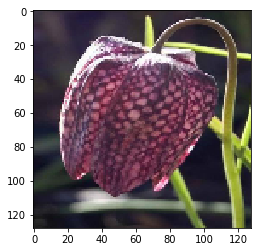

Class probabilities: [1.4790882e-04 5.3133452e-05 6.3913525e-04 2.0596723e-03 9.9710017e-01]
Predicted label: Fritillary

Image 70


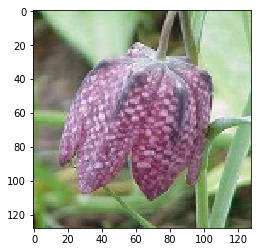

Class probabilities: [0.01558999 0.01642637 0.00738903 0.00753527 0.9530593 ]
Predicted label: Fritillary

Image 71


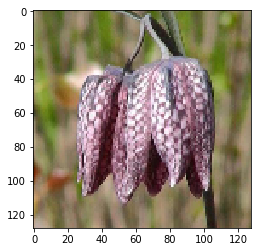

Class probabilities: [1.7558984e-02 3.7380523e-04 7.7684455e-02 1.4676185e-03 9.0291512e-01]
Predicted label: Fritillary

Image 72


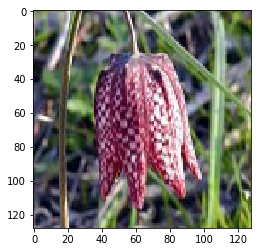

Class probabilities: [5.9189956e-04 6.2123574e-05 3.5810231e-03 2.2260626e-03 9.9353892e-01]
Predicted label: Fritillary

Image 73


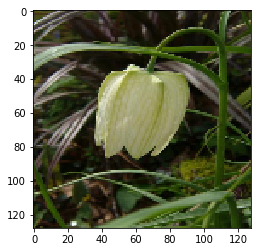

Class probabilities: [0.03714785 0.05097365 0.02660394 0.00240054 0.882874  ]
Predicted label: Fritillary

Image 74


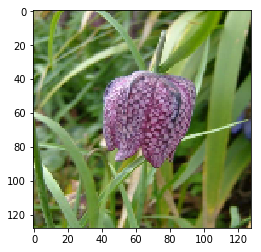

Class probabilities: [0.00630367 0.00104001 0.0513037  0.0588012  0.88255143]
Predicted label: Fritillary

Image 75


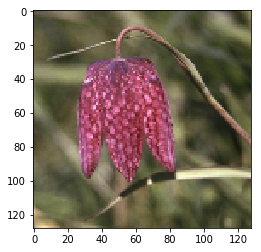

Class probabilities: [0.00109319 0.00165868 0.14594007 0.01048971 0.8408184 ]
Predicted label: Fritillary

Image 76


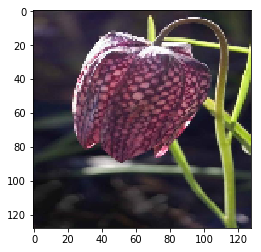

Class probabilities: [1.7393881e-03 7.4579992e-04 3.3242639e-02 3.5575200e-02 9.2869699e-01]
Predicted label: Fritillary

Image 77


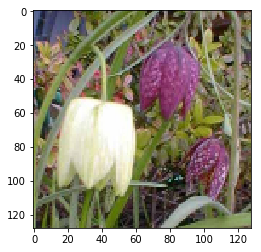

Class probabilities: [0.25416318 0.01680124 0.0135359  0.11538593 0.60011375]
Predicted label: Fritillary

Image 78


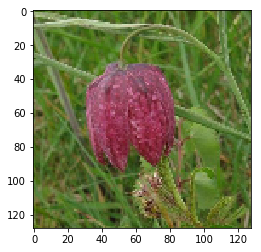

Class probabilities: [4.9985287e-04 8.1928121e-03 1.8067248e-02 2.9945558e-01 6.7378449e-01]
Predicted label: Fritillary

Image 79


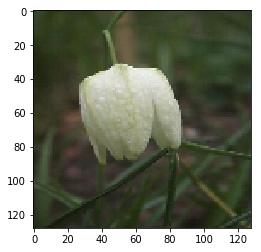

Class probabilities: [6.9819890e-02 5.3917460e-02 6.8719161e-04 6.5995846e-03 8.6897588e-01]
Predicted label: Fritillary

Image 80


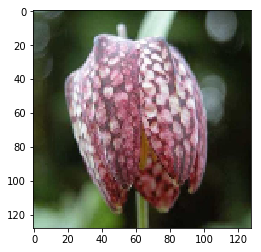

Class probabilities: [2.4308756e-04 2.5250563e-02 6.2901998e-04 2.9164013e-03 9.7096092e-01]
Predicted label: Fritillary

80/80 [==============================] - 1s 13ms/step
Test loss: 0.3733969539403915
Test accuracy: 0.8875



In [9]:
accuracy = test_model(model, visualize=True)

if(RETRAIN):
    save_weigths(model, accuracy)
